In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

In [21]:
batch_size = 128
hidden_layers=512
n_epoch = 15
cuda = True

In [22]:
device = 'cuda' if torch.cuda.is_available() and cuda else 'cpu'
print('Device: {}'.format(device))

Device: cuda


In [23]:
train_dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

test_dataset = torchvision.datasets.MNIST(
    root="data/",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

In [24]:
print('Data shape: {}'.format(train_dataset.data.shape))
print('Targets shape: {}'.format(train_dataset.targets.shape))
print('Class types amount: {}'.format(len(set(train_dataset.targets.numpy()))))

Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])
Class types amount: 10


In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)


In [26]:
class RNN_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_MNIST, self).__init__()
        self.D = input_size
        self.M = hidden_size
        self.L = num_layers
        self.K = output_size
        
        self.rnn_layer = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True,
        )
        
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, inputs):
        h0 = torch.zeros(self.L, inputs.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, inputs.size(0), self.M).to(device)
        
        outputs, _ = self.rnn_layer(inputs, (h0, c0))
        
        outputs = self.fc(outputs[:, -1, :])
        return outputs


In [27]:
model = RNN_MNIST(
    input_size=28,
    hidden_size=128,
    num_layers=2,
    output_size=10,
)
model.to(device)


RNN_MNIST(
  (rnn_layer): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
def validate(
    model,
    dataset,
    test_size=256,
    batch_size=128,
    device='cpu',
):
    loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    total_correct = 0
    total_tested = 0

    for (inputs, targets) in loader:
        if total_tested >= test_size:
            break
        
        inputs = inputs.to(device).view(-1, 28, 28)
        targets = targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        total_correct += sum(predictions == targets)
        total_tested += len(targets)

    return (total_correct / total_tested).item()


In [30]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    n_epoch=10,
    device="cpu",
):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for it in range(n_epoch):
        
        iter_train_loss = []
        iter_test_loss = []

        for (inputs, targets) in train_loader:
            inputs = inputs.to(device).view(-1, 28, 28)
            targets = targets.to(device)

            outputs = model(inputs)

            optimizer.zero_grad()

            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            
            iter_train_loss.append(loss.item())

        train_losses.append(np.mean(iter_train_loss))

        train_accuracies.append(
            validate(
                model=model,
                dataset=train_dataset,
                device=device,
            )
        )

        for (inputs, targets) in test_loader:
            inputs = inputs.to(device).view(-1, 28, 28)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            
            iter_test_loss.append(loss.item())

        test_losses.append(np.mean(iter_test_loss))

        test_accuracies.append(
            validate(
                model=model,
                dataset=train_dataset,
                device=device,
            )
        )

        print(f"Iteration {it + 1:2.0f}/{n_epoch} \t Train Loss: {train_losses[-1]:.4f} \t Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies


In [31]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epoch=n_epoch,
    device=device,
)


Iteration  1/15 	 Train Loss: 0.5348 	 Test Loss: 0.1518
Iteration  2/15 	 Train Loss: 0.1329 	 Test Loss: 0.1072
Iteration  3/15 	 Train Loss: 0.0848 	 Test Loss: 0.0814
Iteration  4/15 	 Train Loss: 0.0615 	 Test Loss: 0.0727
Iteration  5/15 	 Train Loss: 0.0517 	 Test Loss: 0.0604
Iteration  6/15 	 Train Loss: 0.0418 	 Test Loss: 0.0532
Iteration  7/15 	 Train Loss: 0.0361 	 Test Loss: 0.0537
Iteration  8/15 	 Train Loss: 0.0319 	 Test Loss: 0.0433
Iteration  9/15 	 Train Loss: 0.0292 	 Test Loss: 0.0431
Iteration 10/15 	 Train Loss: 0.0276 	 Test Loss: 0.0449
Iteration 11/15 	 Train Loss: 0.0207 	 Test Loss: 0.0460
Iteration 12/15 	 Train Loss: 0.0213 	 Test Loss: 0.0526
Iteration 13/15 	 Train Loss: 0.0201 	 Test Loss: 0.0415
Iteration 14/15 	 Train Loss: 0.0157 	 Test Loss: 0.0398
Iteration 15/15 	 Train Loss: 0.0186 	 Test Loss: 0.0392


<Figure size 432x288 with 0 Axes>

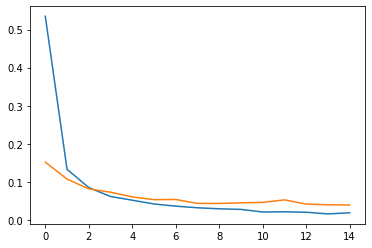

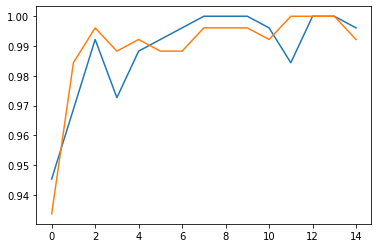

In [32]:
plt.figure(1)
fig, axes = plt.subplots()
axes.plot(train_losses)
axes.plot(test_losses)

plt.figure(2)
fig, axes = plt.subplots()
axes.plot(train_accuracies)
axes.plot(test_accuracies)

In [33]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues
):
    """
    This functions prints and plots Confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix without normalization
[[ 974    0    0    0    0    0    4    1    1    0]
 [   0 1130    1    1    0    0    2    1    0    0]
 [   0    0 1026    0    1    0    1    2    2    0]
 [   0    0    1 1002    0    3    0    1    3    0]
 [   0    0    0    0  973    0    5    2    0    2]
 [   0    0    0    7    0  881    1    0    2    1]
 [   1    4    1    0    1    8  941    0    2    0]
 [   1    4    7    0    1    0    0 1011    1    3]
 [   1    0    2    1    0    3    0    3  964    0]
 [   0    0    0    1   12    4    0    4    2  986]]


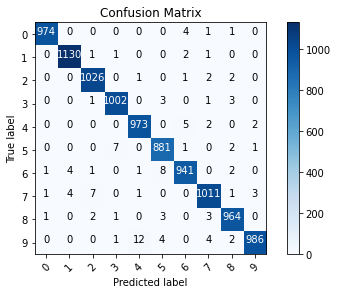

In [34]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device).view(-1, 28, 28), targets.to(device)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))